In [1]:
import random; random.seed(42)
!pip install -q evaluate torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from datasets import Dataset
import evaluate
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from torchinfo import summary
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
random.seed(42)

## Load Datasets, Tokenizer, and Model

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DS266/Project/Data/combined_test.csv')

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

## Multi-Label Prediction

In [6]:
example = train_dataset[0]
example

{'text_cleaned': 'يلعن شرفك يا حكم!!!',
 'language': 'arabic',
 'directness_label': 2,
 'target_label': 2,
 'group_label': 12,
 'hatespeech': 0,
 'hatespeech.1': 0,
 'directness_label.1': 2,
 'target_label.1': 2,
 'group_label.1': 12,
 'sentiment_anger': 0,
 'sentiment_confusion': 0,
 'sentiment_disgust': 0,
 'sentiment_fear': 0,
 'sentiment_indifference': 0,
 'sentiment_normal': 1,
 'sentiment_sadness': 0,
 'sentiment_shock': 0,
 'language_encoded': 2}

In [7]:
from datasets import DatasetDict

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'hatespeech.1', 'directness_label.1', 'target_label.1', 'group_label.1', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock', 'language_encoded'],
        num_rows: 30702
    })
    validation: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'hatespeech.1', 'directness_label.1', 'target_label.1', 'group_label.1', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock', 'language_encoded'],
        num_rows: 3901
    })
    test: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 

In [8]:
example = dataset['train'][13000]
example

{'text_cleaned': "c'est un gros mongol quand même",
 'language': 'french',
 'directness_label': 0,
 'target_label': 3,
 'group_label': 8,
 'hatespeech': 1,
 'hatespeech.1': 1,
 'directness_label.1': 0,
 'target_label.1': 3,
 'group_label.1': 8,
 'sentiment_anger': 0,
 'sentiment_confusion': 0,
 'sentiment_disgust': 0,
 'sentiment_fear': 0,
 'sentiment_indifference': 0,
 'sentiment_normal': 0,
 'sentiment_sadness': 0,
 'sentiment_shock': 1,
 'language_encoded': 1}

In [9]:
# Original binary labels
binary_label_columns = [
    'hatespeech',
    'sentiment_indifference',
    'sentiment_disgust',
    'sentiment_sadness',
    'sentiment_anger',
    'sentiment_shock',
    'sentiment_normal',
    'sentiment_confusion',
    'sentiment_fear'
]

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

# Create names for one-hot encoded binary labels
directness_binary_labels = [f'directness_label_{val}' for val in directness_values]
target_binary_labels = [f'target_label_{val}' for val in target_values]
group_binary_labels = [f'group_label_{val}' for val in group_values]

# Combine all binary label names
all_binary_labels = binary_label_columns + directness_binary_labels + target_binary_labels + group_binary_labels

# Update id2label and label2id
id2label = {idx:label for idx, label in enumerate(all_binary_labels)}
label2id = {label:idx for idx, label in enumerate(all_binary_labels)}

# The total number of binary labels
num_binary_labels = len(all_binary_labels)

print(f"Total number of binary labels: {num_binary_labels}")
print(f"All binary labels: {all_binary_labels}")

Total number of binary labels: 36
All binary labels: ['hatespeech', 'sentiment_indifference', 'sentiment_disgust', 'sentiment_sadness', 'sentiment_anger', 'sentiment_shock', 'sentiment_normal', 'sentiment_confusion', 'sentiment_fear', 'directness_label_0', 'directness_label_1', 'directness_label_2', 'target_label_0', 'target_label_1', 'target_label_2', 'target_label_3', 'target_label_4', 'target_label_5', 'target_label_6', 'group_label_0', 'group_label_1', 'group_label_2', 'group_label_3', 'group_label_4', 'group_label_5', 'group_label_6', 'group_label_7', 'group_label_8', 'group_label_9', 'group_label_10', 'group_label_11', 'group_label_12', 'group_label_13', 'group_label_14', 'group_label_15', 'group_label_16']


In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-multilingual-cased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-multilingual-cased",
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(all_binary_labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import torch
import numpy as np

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

def preprocess_multioutput_data(examples):
  # take a batch of texts
  text = [str(x) for x in examples["text_cleaned"]]
  # encode them, returning PyTorch tensors directly
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=150, return_tensors="pt")

  # Create list of binary label tensors
  binary_labels_list = [
      torch.tensor(examples["hatespeech"]),
      torch.tensor(examples["sentiment_anger"]),
      torch.tensor(examples["sentiment_confusion"]),
      torch.tensor(examples["sentiment_disgust"]),
      torch.tensor(examples["sentiment_fear"]),
      torch.tensor(examples["sentiment_indifference"]),
      torch.tensor(examples["sentiment_normal"]),
      torch.tensor(examples["sentiment_sadness"]),
      torch.tensor(examples["sentiment_shock"])
  ]

  # Perform one-hot encoding for multiclass labels and add to the list
  for i, val in enumerate(directness_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["directness_label"]]))

  for i, val in enumerate(target_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["target_label"]]))

  for i, val in enumerate(group_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["group_label"]]))


  # Stack all binary label tensors along dimension 1
  labels_tensor = torch.stack(binary_labels_list, dim=1).float()

  # Add the stacked labels tensor to the encoding dictionary
  encoding['labels'] = labels_tensor

  return encoding

In [12]:


# Apply the preprocessing function with batching
encoded_dataset = dataset.map(preprocess_multioutput_data, batched=True, remove_columns=dataset['train'].column_names)


Map:   0%|          | 0/30702 [00:00<?, ? examples/s]

Map:   0%|          | 0/3901 [00:00<?, ? examples/s]

Map:   0%|          | 0/3901 [00:00<?, ? examples/s]

In [13]:
example = encoded_dataset['train'][13000]
print(example.keys())

print(tokenizer.decode(example['input_ids']))

print(example)

dict_keys(['input_ids', 'attention_mask', 'labels'])
[CLS] c ' est un gros mongol quand même [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
{'input_ids': [101, 171, 112, 10176, 10119, 46505, 34372, 31002, 20

In [14]:
for name, param in model.named_parameters():
    print(name)

distilbert.embeddings.word_embeddings.weight
distilbert.embeddings.position_embeddings.weight
distilbert.embeddings.LayerNorm.weight
distilbert.embeddings.LayerNorm.bias
distilbert.transformer.layer.0.attention.q_lin.weight
distilbert.transformer.layer.0.attention.q_lin.bias
distilbert.transformer.layer.0.attention.k_lin.weight
distilbert.transformer.layer.0.attention.k_lin.bias
distilbert.transformer.layer.0.attention.v_lin.weight
distilbert.transformer.layer.0.attention.v_lin.bias
distilbert.transformer.layer.0.attention.out_lin.weight
distilbert.transformer.layer.0.attention.out_lin.bias
distilbert.transformer.layer.0.sa_layer_norm.weight
distilbert.transformer.layer.0.sa_layer_norm.bias
distilbert.transformer.layer.0.ffn.lin1.weight
distilbert.transformer.layer.0.ffn.lin1.bias
distilbert.transformer.layer.0.ffn.lin2.weight
distilbert.transformer.layer.0.ffn.lin2.bias
distilbert.transformer.layer.0.output_layer_norm.weight
distilbert.transformer.layer.0.output_layer_norm.bias
distil

In [15]:
# Freeze all of the pre-trained BERT layers to make the fine tuning go much faster.
# Then later we'll try unfreezing some or all layers and see what works better.
# We need to keep the final classification layer unfrozen no matter what,
# because that's a new layer that hasn't been trained at all yet, and needs to be trained for our task.


for name, param in model.distilbert.named_parameters():
    param.requires_grad = False

In [16]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (91,812,096)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           27,684
├─Dropout: 1-4                                          --
Total params: 135,352,356
Trainable params: 618,276
Non-trainable params: 134,734,080

In [17]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score
from transformers import EvalPrediction
import torch
import numpy as np # Import numpy

def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels.astype(int) # Ensure labels are integers
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true.flatten(), y_pred.flatten())
    precision = precision_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    recall = recall_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'balanced_accuracy': balanced_accuracy,
               'precision': precision,
               'recall': recall}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions

    # Ensure labels are a 2D numpy array of integers
    labels_np = np.array(p.label_ids)
    if labels_np.ndim == 1:
        # This might happen if the batch size is 1, reshape to (1, num_labels)
        labels_np = labels_np.reshape(1, -1)
    elif labels_np.ndim > 2:
        # Handle cases where labels might have extra dimensions unexpectedly
        # This might require more specific reshaping based on the actual structure
        # For now, let's assume the expected shape is (batch_size, num_labels)
        # and try to flatten and reshape if necessary.
        # A safer approach might be to raise an error or log a warning here.
        print(f"Warning: Unexpected label dimension: {labels_np.ndim}")
        # Attempt to flatten and reshape - adjust if your data structure is different
        labels_np = labels_np.reshape(labels_np.shape[0], -1)


    result = multi_label_metrics(
        predictions=preds,
        labels=labels_np)
    return result

In [18]:
#forward pass
# # Check the type of the data after setting the format
# print(f"Type of input_ids[0]: {encoded_dataset['train']['input_ids'][0].type()}")
# print(f"Type of labels[0]: {encoded_dataset['train'][0]['hatespeech_labels'].type()}")

# Also print a sample example to see the structure
print("Sample example after setting format:")
print(encoded_dataset['train'][0])

# Manually get a sample and prepare input for the model
sample = encoded_dataset['train'][0]

# Convert lists to PyTorch tensors before unsqueezing
input_ids_tensor = torch.tensor(sample['input_ids']).unsqueeze(0)
attention_mask_tensor = torch.tensor(sample['attention_mask']).unsqueeze(0)
labels_tensor = torch.tensor(sample['labels']).unsqueeze(0)

# Move tensors to the same device as the model
device = model.device
input_ids_tensor = input_ids_tensor.to(device)
attention_mask_tensor = attention_mask_tensor.to(device)
labels_tensor = labels_tensor.to(device)


outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor, labels=labels_tensor)
outputs

Sample example after setting format:
{'input_ids': [101, 793, 10961, 11693, 10582, 776, 29573, 12497, 60844, 59213, 106, 106, 106, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

SequenceClassifierOutput(loss=tensor(0.6883, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.1054, -0.1147,  0.0567,  0.0788,  0.1114,  0.0757,  0.0848, -0.0479,
          0.1253,  0.0025,  0.1157,  0.0846, -0.0684, -0.0735,  0.0115, -0.0764,
          0.0978, -0.1414,  0.1414,  0.0568, -0.1070, -0.0276,  0.0328,  0.0781,
         -0.0210,  0.0515, -0.1301,  0.0266,  0.1101, -0.2042, -0.0803,  0.0548,
         -0.0379, -0.1335, -0.0227,  0.0422]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

# 1. Increase batch size and unfreeze layer 5

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

batch_size = 128
metric_name = "eval_f1"

args = TrainingArguments(
    f"distilbert-base-multilingual-cased",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=100, # Set logging steps to a smaller value
    greater_is_better=True, # F1 score is better when higher
    report_to='none' # Disable reporting to wandb for this example
)

# Add EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3, # Number of evaluation epochs to wait before stopping
    early_stopping_threshold=0.0 # Minimum improvement to consider as progress
)

In [ ]:
# Unfreeze classifier, pooler, and layer 5

for name, param in model.named_parameters():
    if name.split(".")[0] == "distilbert" and "transformer.layer.5" in name:
        param.requires_grad = True
    elif name in ["pre_classifier.weight", "pre_classifier.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = True
    else:
        param.requires_grad = False

summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (91,812,096)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           27,684
├─Dropout: 1-4                                          --
Total params: 135,352,356
Trainable params: 7,706,148
Non-trainable params: 127,646,208

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-21-3132099784.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print(encoded_dataset['train']['labels'][13000])

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Balanced Accuracy,Precision,Recall
1,0.230200,0.206895,0.634783,0.753883,0.458857,0.753883,0.786961,0.531922
2,0.195300,0.183691,0.686328,0.785541,0.451679,0.785541,0.812487,0.594081
3,0.176900,0.171017,0.706855,0.797488,0.464753,0.797488,0.828448,0.616387
4,0.169500,0.166445,0.716514,0.806499,0.466291,0.806499,0.819516,0.636512
5,0.163500,0.164759,0.718796,0.806589,0.465009,0.806589,0.827353,0.635422


TrainOutput(global_step=1200, training_loss=0.20143890539805095, metrics={'train_runtime': 971.3734, 'train_samples_per_second': 158.034, 'train_steps_per_second': 1.235, 'total_flos': 5961152451996000.0, 'train_loss': 0.20143890539805095, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.1647585928440094,
 'eval_f1': 0.7187955590445217,
 'eval_roc_auc': 0.8065893637594532,
 'eval_accuracy': 0.46500897205844655,
 'eval_balanced_accuracy': 0.8065893637594533,
 'eval_precision': 0.8273525235575061,
 'eval_recall': 0.6354218300783187,
 'eval_runtime': 16.9072,
 'eval_samples_per_second': 230.731,
 'eval_steps_per_second': 1.834,
 'epoch': 5.0}

# 2. Unfreeze layer 4

In [ ]:
# Unfreeze classifier, pooler, and layer 4 and 5

for name, param in model.named_parameters():
    if name.split(".")[0] == "distilbert" and "transformer.layer.5" in name:
        param.requires_grad = True
    elif name.split(".")[0] == "distilbert" and "transformer.layer.4" in name:
        param.requires_grad = True
    elif name in ["pre_classifier.weight", "pre_classifier.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = True
    else:
        param.requires_grad = False

summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (91,812,096)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           27,684
├─Dropout: 1-4                                          --
Total params: 135,352,356
Trainable params: 14,794,020
Non-trainable params: 120,558,336

In [ ]:
args = TrainingArguments(
    f"distilbert-base-multilingual-cased",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=100, # Set logging steps to a smaller value
    greater_is_better=True, # F1 score is better when higher
    report_to='none' # Disable reporting to wandb for this example
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-26-2222263921.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Balanced Accuracy,Precision,Recall
1,0.155100,0.153013,0.742594,0.825626,0.470136,0.825626,0.824747,0.675325
2,0.145400,0.147895,0.748663,0.829823,0.469623,0.829823,0.827483,0.683553
3,0.141100,0.146247,0.751690,0.832425,0.473212,0.832425,0.826850,0.689055
4,0.139000,0.144922,0.754363,0.835228,0.475519,0.835228,0.824390,0.695301
5,0.135000,0.144463,0.752964,0.832238,0.479621,0.832238,0.831745,0.687816


TrainOutput(global_step=1200, training_loss=0.14405954122543335, metrics={'train_runtime': 1164.7951, 'train_samples_per_second': 131.791, 'train_steps_per_second': 1.03, 'total_flos': 5961152451996000.0, 'train_loss': 0.14405954122543335, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.14492227137088776,
 'eval_f1': 0.7543628492296109,
 'eval_roc_auc': 0.8352275644427283,
 'eval_accuracy': 0.4755190976672648,
 'eval_balanced_accuracy': 0.8352275644427284,
 'eval_precision': 0.824390243902439,
 'eval_recall': 0.6953008823237831,
 'eval_runtime': 16.8632,
 'eval_samples_per_second': 231.332,
 'eval_steps_per_second': 1.838,
 'epoch': 5.0}

# 3. Increase Learning Rate

In [ ]:
args = TrainingArguments(
    f"distilbert-base-multilingual-cased",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=100, # Set logging steps to a smaller value
    greater_is_better=True, # F1 score is better when higher
    report_to='none' # Disable reporting to wandb for this example
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-28-2918426528.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Balanced Accuracy,Precision,Recall
1,0.136500,0.144067,0.753989,0.833575,0.476801,0.833575,0.829702,0.690939
2,0.131100,0.144019,0.757651,0.837426,0.473468,0.837426,0.826326,0.699514
3,0.129400,0.143439,0.759327,0.838541,0.477314,0.838541,0.827342,0.701646
4,0.129400,0.143768,0.759251,0.839497,0.477826,0.839497,0.823471,0.704322
5,0.126400,0.143984,0.758676,0.837419,0.480646,0.837419,0.829607,0.698919


TrainOutput(global_step=1200, training_loss=0.1307869823773702, metrics={'train_runtime': 1137.0083, 'train_samples_per_second': 135.012, 'train_steps_per_second': 1.055, 'total_flos': 5961152451996000.0, 'train_loss': 0.1307869823773702, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.14343906939029694,
 'eval_f1': 0.7593273073518761,
 'eval_roc_auc': 0.8385413225966504,
 'eval_accuracy': 0.47731350935657524,
 'eval_balanced_accuracy': 0.8385413225966505,
 'eval_precision': 0.82734233444386,
 'eval_recall': 0.7016456825617131,
 'eval_runtime': 16.8469,
 'eval_samples_per_second': 231.556,
 'eval_steps_per_second': 1.84,
 'epoch': 5.0}

# 4. Unfreeze layer 3

In [19]:
# Unfreeze classifier, pooler, and layer 3, 4, and 5

for name, param in model.named_parameters():
    if name.split(".")[0] == "distilbert" and "transformer.layer.5" in name:
        param.requires_grad = True
    elif name.split(".")[0] == "distilbert" and "transformer.layer.4" in name:
        param.requires_grad = True
    elif name.split(".")[0] == "distilbert" and "transformer.layer.3" in name:
        param.requires_grad = True
    elif name in ["pre_classifier.weight", "pre_classifier.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = True
    else:
        param.requires_grad = False

summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (91,812,096)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           27,684
├─Dropout: 1-4                                          --
Total params: 135,352,356
Trainable params: 21,881,892
Non-trainable params: 113,470,464

In [22]:
batch_size = 128
metric_name = "eval_f1"

args = TrainingArguments(
    f"distilbert-base-multilingual-cased",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=100, # Set logging steps to a smaller value
    greater_is_better=True, # F1 score is better when higher
    report_to='none' # Disable reporting to wandb for this example
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-22-1656978199.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Balanced Accuracy,Precision,Recall
1,0.181500,0.157615,0.733238,0.814773,0.474494,0.814773,0.840520,0.650243
2,0.148800,0.146972,0.756714,0.840861,0.475519,0.840861,0.810624,0.709527
3,0.139000,0.143065,0.758493,0.838371,0.478083,0.838371,0.825364,0.701646
4,0.137000,0.142823,0.755536,0.833244,0.482440,0.833244,0.836070,0.689154
5,0.132200,0.142607,0.757555,0.836993,0.481671,0.836993,0.827694,0.698374


TrainOutput(global_step=1200, training_loss=0.15994088808695475, metrics={'train_runtime': 1309.1163, 'train_samples_per_second': 117.262, 'train_steps_per_second': 0.917, 'total_flos': 5961152451996000.0, 'train_loss': 0.15994088808695475, 'epoch': 5.0})

In [23]:
trainer.evaluate()

{'eval_loss': 0.1430649757385254,
 'eval_f1': 0.7584931947272533,
 'eval_roc_auc': 0.8383708614368492,
 'eval_accuracy': 0.4780825429377083,
 'eval_balanced_accuracy': 0.8383708614368492,
 'eval_precision': 0.8253644314868804,
 'eval_recall': 0.7016456825617131,
 'eval_runtime': 16.3081,
 'eval_samples_per_second': 239.206,
 'eval_steps_per_second': 1.901,
 'epoch': 5.0}

In [ ]:
# learning rate back down
args = TrainingArguments(
    f"distilbert-base-multilingual-cased",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=100, # Set logging steps to a smaller value
    greater_is_better=True, # F1 score is better when higher
    report_to='none' # Disable reporting to wandb for this example
)
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-33-594160490.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Balanced Accuracy,Precision,Recall
1,0.119000,0.146034,0.759618,0.840940,0.480390,0.840940,0.819235,0.708090
2,0.115200,0.148273,0.761091,0.843963,0.478852,0.843963,0.812792,0.715575
3,0.118600,0.150888,0.757136,0.840643,0.478339,0.840643,0.812699,0.708684
4,0.119900,0.151767,0.755326,0.839478,0.483722,0.839478,0.811397,0.706503
5,0.115800,0.153578,0.754022,0.837881,0.482440,0.837881,0.813249,0.702835


TrainOutput(global_step=1200, training_loss=0.1179073174794515, metrics={'train_runtime': 1370.9066, 'train_samples_per_second': 111.977, 'train_steps_per_second': 0.875, 'total_flos': 5961152451996000.0, 'train_loss': 0.1179073174794515, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.14827343821525574,
 'eval_f1': 0.7610913404507711,
 'eval_roc_auc': 0.843963266616079,
 'eval_accuracy': 0.4788515765188413,
 'eval_balanced_accuracy': 0.843963266616079,
 'eval_precision': 0.8127920725184393,
 'eval_recall': 0.7155745018340438,
 'eval_runtime': 17.3203,
 'eval_samples_per_second': 225.227,
 'eval_steps_per_second': 1.79,
 'epoch': 5.0}

# 5. Unfreeze layer 2, add layer-wise learning rates, and learning rate scheduler

In [ ]:
# Unfreeze classifier, pooler, and layer 3, 4, and 5

for name, param in model.named_parameters():
    if name.split(".")[0] == "distilbert" and "transformer.layer.5" in name:
        param.requires_grad = True
    elif name.split(".")[0] == "distilbert" and "transformer.layer.4" in name:
        param.requires_grad = True
    elif name.split(".")[0] == "distilbert" and "transformer.layer.3" in name:
        param.requires_grad = True
    elif name.split(".")[0] == "distilbert" and "transformer.layer.2" in name:
        param.requires_grad = True
    elif name in ["pre_classifier.weight", "pre_classifier.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = True
    else:
        param.requires_grad = False

summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (91,812,096)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           27,684
├─Dropout: 1-4                                          --
Total params: 135,352,356
Trainable params: 28,969,764
Non-trainable params: 106,382,592

In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler

# Define different learning rates for different layers
learning_rate_classifier = 4e-5  # Higher learning rate for the new classifier layer
learning_rate_unfrozen_layers = 3e-5 # Slightly increased learning rate for the unfrozen DistilBERT layers
# You could define even lower learning rates for layers further down if you unfreeze more

# Separate parameters into groups
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if "distilbert" not in n],
        "lr": learning_rate_classifier,
    },
    {
        "params": [p for n, p in model.named_parameters() if "distilbert.transformer.layer.5" in n],
        "lr": learning_rate_unfrozen_layers,
    },
    {
        "params": [p for n, p in model.named_parameters() if "distilbert.transformer.layer.4" in n],
        "lr": learning_rate_unfrozen_layers,
    },
    {
        "params": [p for n, p in model.named_parameters() if "distilbert.transformer.layer.3" in n],
        "lr": learning_rate_unfrozen_layers,
    },
    {
        "params": [p for n, p in model.named_parameters() if "distilbert.transformer.layer.2" in n],
        "lr": learning_rate_unfrozen_layers,
    },
    # Add more groups here if you unfreeze more layers, with potentially even lower learning rates
]

# Create a custom optimizer
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate_classifier) # The `lr` here is a default, it will be overridden by the group LRs

# batch size up
batch_size = 256
metric_name = "eval_f1"

# Now, when initializing the Trainer, pass the custom optimizer
# Note: You might need to adjust the TrainingArguments as the optimizer is now handled manually
# specifically, remove the `learning_rate` argument from TrainingArguments
args = TrainingArguments(
    f"distilbert-base-multilingual-cased_layerwise_lr_scheduler", # Give a new output directory name
    eval_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.1, # increase regularization
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=100,
    greater_is_better=True,
    report_to='none',
    lr_scheduler_type="cosine" # Added learning rate scheduler
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None) # Pass the custom optimizer
)

# Now you can train with layer-wise learning rates and scheduler
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Balanced Accuracy,Precision,Recall
1,0.116100,0.153723,0.752899,0.841871,0.485004,0.841871,0.795618,0.714534
2,0.113700,0.161089,0.748723,0.837487,0.486029,0.837487,0.798461,0.704818
3,0.110800,0.165717,0.748847,0.838852,0.486798,0.838852,0.794023,0.708536
4,0.109200,0.170552,0.747352,0.837786,0.490387,0.837786,0.793276,0.706454
5,0.107300,0.170848,0.750013,0.839991,0.489362,0.839991,0.793538,0.711014


TrainOutput(global_step=600, training_loss=0.11080339272816976, metrics={'train_runtime': 1480.3735, 'train_samples_per_second': 103.697, 'train_steps_per_second': 0.405, 'total_flos': 5961152451996000.0, 'train_loss': 0.11080339272816976, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.14186878502368927,
 'eval_f1': 0.7619350226388116,
 'eval_roc_auc': 0.8432725272830801,
 'eval_accuracy': 0.48013329915406305,
 'eval_balanced_accuracy': 0.8432725272830801,
 'eval_precision': 0.8178252714147672,
 'eval_recall': 0.7131952017448201,
 'eval_runtime': 16.349,
 'eval_samples_per_second': 238.607,
 'eval_steps_per_second': 0.979,
 'epoch': 10.0}

In [ ]:
text = "I'm happy I can finally train a model for multi-label classification"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [ ]:
logits = outputs.logits
logits.shape

torch.Size([1, 36])

In [ ]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print("Predicted labels (names):", predicted_labels)
print("Predicted labels (binary values):", predictions)

Predicted labels (names): ['sentiment_normal', 'directness_label_2', 'target_label_2', 'group_label_12']
Predicted labels (binary values): [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
true_labels = []
predicted_logits = []

device = trainer.model.device

for sample in encoded_dataset["validation"]:
    inputs = {
        'input_ids': torch.tensor([sample['input_ids']]).to(device),
        'attention_mask': torch.tensor([sample['attention_mask']]).to(device)
    }

    with torch.no_grad():
        outputs = trainer.model(**inputs)

    # Append the true labels and predicted logits
    true_labels.append(sample['labels'])
    predicted_logits.append(outputs.logits.squeeze().cpu().numpy())


In [ ]:
# Convert lists to numpy arrays
true_labels_np = np.array(true_labels)
predicted_logits_np = np.array(predicted_logits)

# Define indices for each label group based on all_binary_labels
hatespeech_idx = all_binary_labels.index('hatespeech')
sentiment_indices = [all_binary_labels.index(label) for label in binary_label_columns if 'sentiment' in label]
directness_indices = [all_binary_labels.index(label) for label in directness_binary_labels]
target_indices = [all_binary_labels.index(label) for label in target_binary_labels]
group_indices = [all_binary_labels.index(label) for label in group_binary_labels]


# Split true labels and predicted logits
true_hatespeech = true_labels_np[:, hatespeech_idx]
predicted_hatespeech_logits = predicted_logits_np[:, hatespeech_idx]

true_sentiment_labels = true_labels_np[:, sentiment_indices]
predicted_sentiment_logits = predicted_logits_np[:, sentiment_indices]

true_directness_labels = true_labels_np[:, directness_indices]
predicted_directness_logits = predicted_logits_np[:, directness_indices]

true_target_labels = true_labels_np[:, target_indices]
predicted_target_logits = predicted_logits_np[:, target_indices]

true_group_labels = true_labels_np[:, group_indices]
predicted_group_logits = predicted_logits_np[:, group_indices]

print("True Hatespeech Labels shape:", true_hatespeech.shape)
print("Predicted Hatespeech Logits shape:", predicted_hatespeech_logits.shape)
print("True Sentiment Labels shape:", true_sentiment_labels.shape)
print("Predicted Sentiment Logits shape:", predicted_sentiment_logits.shape)
print("True Directness Labels shape:", true_directness_labels.shape)
print("Predicted Directness Logits shape:", predicted_directness_logits.shape)
print("True Target Labels shape:", true_target_labels.shape)
print("Predicted Target Logits shape:", predicted_target_logits.shape)
print("True Group Labels shape:", true_group_labels.shape)
print("Predicted Group Logits shape:", predicted_group_logits.shape)

True Hatespeech Labels shape: (3901,)
Predicted Hatespeech Logits shape: (3901,)
True Sentiment Labels shape: (3901, 8)
Predicted Sentiment Logits shape: (3901, 8)
True Directness Labels shape: (3901, 3)
Predicted Directness Logits shape: (3901, 3)
True Target Labels shape: (3901, 7)
Predicted Target Logits shape: (3901, 7)
True Group Labels shape: (3901, 17)
Predicted Group Logits shape: (3901, 17)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_metrics_and_confusion_matrix(true_labels, predicted_logits, threshold=0.5, is_multilabel=True):
    """
    Calculates classification metrics and confusion matrix.

    Args:
        true_labels (np.ndarray): True labels (binary).
        predicted_logits (np.ndarray): Predicted logits from the model.
        threshold (float): Threshold to convert probabilities to binary predictions.
        is_multilabel (bool): Whether the task is multi-label classification.

    Returns:
        dict: Dictionary containing accuracy, precision, recall, and F1 score.
        np.ndarray: Confusion matrix.
    """
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predicted_logits)).numpy()

    if is_multilabel:
        # For multi-label, apply threshold to each label independently
        predicted_labels = (probs >= threshold).astype(int)
    else:
        # For binary (hatespeech), apply threshold to the single output
        predicted_labels = (probs >= threshold).astype(int)


    # Calculate metrics
    accuracy = accuracy_score(true_labels.flatten(), predicted_labels.flatten())
    balanced_accuracy = balanced_accuracy_score(true_labels.flatten(), predicted_labels.flatten())
    precision = precision_score(true_labels.flatten(), predicted_labels.flatten(), average='micro', zero_division=0)
    recall = recall_score(true_labels.flatten(), predicted_labels.flatten(), average='micro', zero_division=0)
    f1 = f1_score(true_labels.flatten(), predicted_labels.flatten(), average='micro', zero_division=0)

    # Calculate confusion matrix - Note: For multi-label, CM is often calculated per label or overall
    # A simple overall CM for multilabel can be misleading. We'll calculate it based on flattened arrays
    # which treats each label prediction as a separate instance.
    cm = confusion_matrix(true_labels.flatten(), predicted_labels.flatten())


    metrics = {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    return metrics, cm

# Calculate metrics and confusion matrices for each group

# Hatespeech (Binary Classification)
hatespeech_metrics, hatespeech_cm = calculate_metrics_and_confusion_matrix(
    true_hatespeech, predicted_hatespeech_logits, is_multilabel=False
)
print("Hatespeech Metrics:", hatespeech_metrics)
print("Hatespeech Confusion Matrix:\n", hatespeech_cm)


# Sentiment (Multi-label Classification)
sentiment_metrics, sentiment_cm = calculate_metrics_and_confusion_matrix(
    true_sentiment_labels, predicted_sentiment_logits, is_multilabel=True
)
print("\nSentiment Metrics (Micro Avg):", sentiment_metrics)
print("Sentiment Confusion Matrix (Flattened):\n", sentiment_cm)


# Directness (Multi-label Classification - treated as binary for each category)
directness_metrics, directness_cm = calculate_metrics_and_confusion_matrix(
    true_directness_labels, predicted_directness_logits, is_multilabel=True
)
print("\nDirectness Metrics (Micro Avg):", directness_metrics)
print("Directness Confusion Matrix (Flattened):\n", directness_cm)

# Target (Multi-label Classification - treated as binary for each category)
target_metrics, target_cm = calculate_metrics_and_confusion_matrix(
    true_target_labels, predicted_target_logits, is_multilabel=True
)
print("\nTarget Metrics (Micro Avg):", target_metrics)
print("Target Confusion Matrix (Flattened):\n", target_cm)

# Group (Multi-label Classification - treated as binary for each category)
group_metrics, group_cm = calculate_metrics_and_confusion_matrix(
    true_group_labels, predicted_group_logits, is_multilabel=True
)
print("\nGroup Metrics (Micro Avg):", group_metrics)
print("Group Confusion Matrix (Flattened):\n", group_cm)

Hatespeech Metrics: {'accuracy': 0.9497564726993079, 'balanced_accuracy': np.float64(0.9509577772513096), 'precision': 0.9497564726993079, 'recall': 0.9497564726993079, 'f1': 0.9497564726993079}
Hatespeech Confusion Matrix:
 [[1862  163]
 [  33 1843]]

Sentiment Metrics (Micro Avg): {'accuracy': 0.8581453473468341, 'balanced_accuracy': np.float64(0.7576078575807634), 'precision': 0.8581453473468341, 'recall': 0.8581453473468341, 'f1': 0.8581453473468341}
Sentiment Confusion Matrix (Flattened):
 [[22933  1680]
 [ 2747  3848]]

Directness Metrics (Micro Avg): {'accuracy': 0.8964368110740836, 'balanced_accuracy': np.float64(0.8759933350422968), 'precision': 0.8964368110740836, 'recall': 0.8964368110740836, 'f1': 0.8964368110740836}
Directness Confusion Matrix (Flattened):
 [[7313  489]
 [ 723 3178]]

Target Metrics (Micro Avg): {'accuracy': 0.9466437177280551, 'balanced_accuracy': np.float64(0.8709305306331709), 'precision': 0.9466437177280551, 'recall': 0.9466437177280551, 'f1': 0.946643

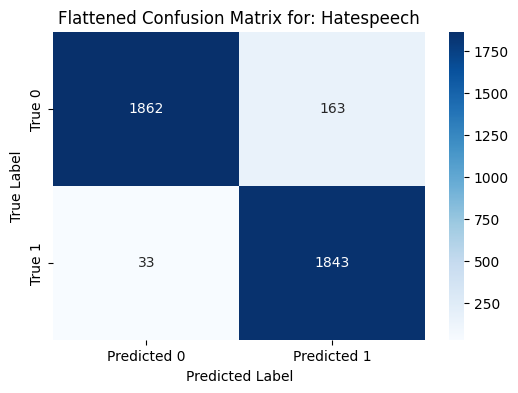

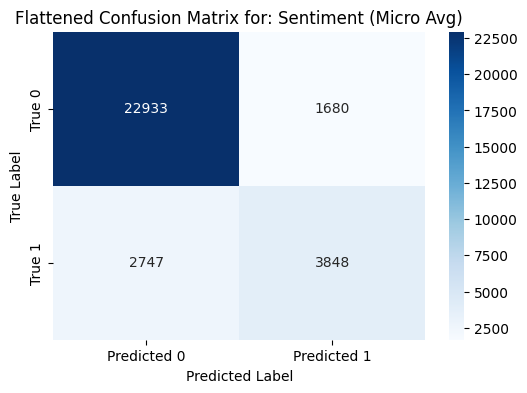

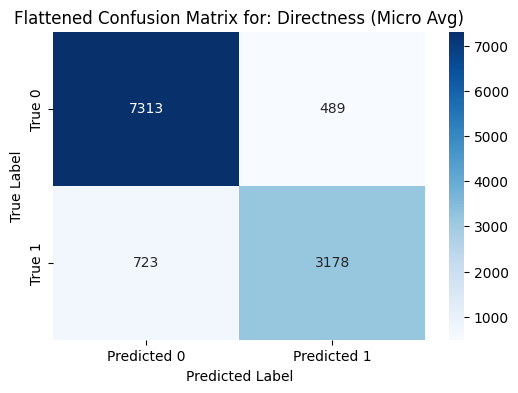

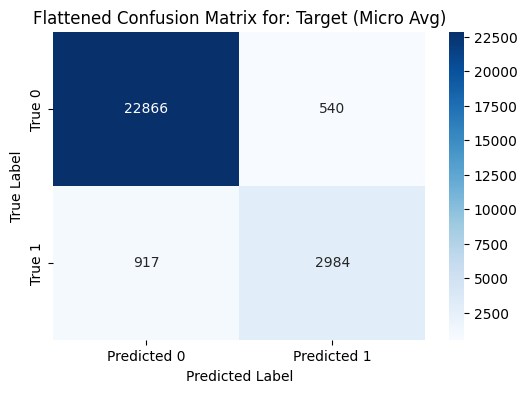

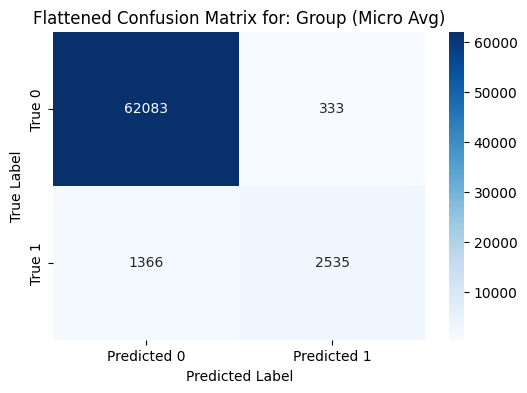

In [ ]:
# Visualize Flattened Confusion Matrices for each group

# Hatespeech Flattened Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(hatespeech_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Flattened Confusion Matrix for: Hatespeech')
plt.show()

# Sentiment Flattened Confusion Matrix (Micro Avg across labels)
# Note: This matrix is based on the flattened true and predicted labels across all sentiment types.
plt.figure(figsize=(6, 4))
sns.heatmap(sentiment_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Flattened Confusion Matrix for: Sentiment (Micro Avg)')
plt.show()

# Directness Flattened Confusion Matrix (Micro Avg across categories)
# Note: This matrix is based on the flattened true and predicted labels across all directness categories.
plt.figure(figsize=(6, 4))
sns.heatmap(directness_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Flattened Confusion Matrix for: Directness (Micro Avg)')
plt.show()


# Target Flattened Confusion Matrix (Micro Avg across categories)
# Note: This matrix is based on the flattened true and predicted labels across all target categories.
plt.figure(figsize=(6, 4))
sns.heatmap(target_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Flattened Confusion Matrix for: Target (Micro Avg)')
plt.show()

# Group Flattened Confusion Matrix (Micro Avg across categories)
# Note: This matrix is based on the flattened true and predicted labels across all group categories.
plt.figure(figsize=(6, 4))
sns.heatmap(group_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Flattened Confusion Matrix for: Group (Micro Avg)')
plt.show()

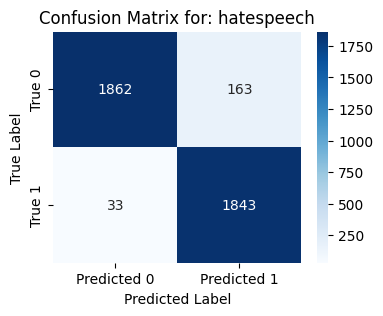

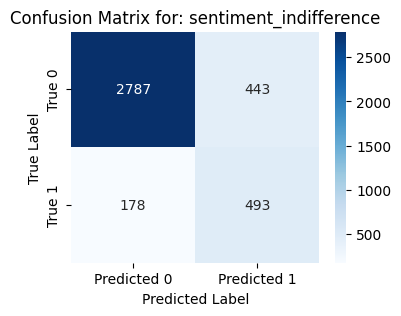

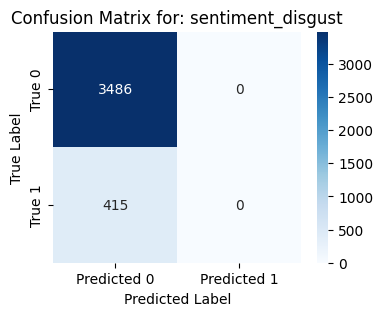

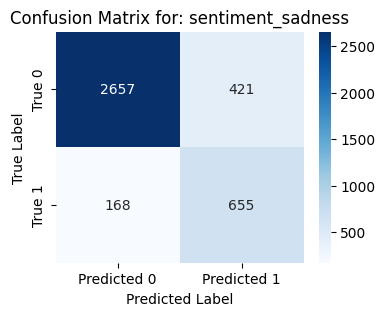

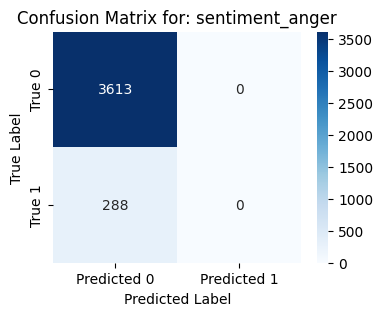

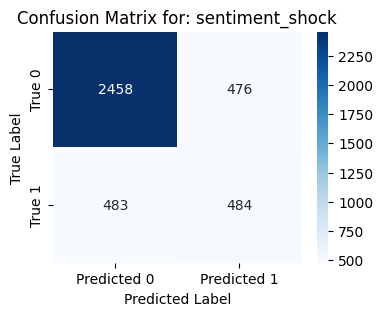

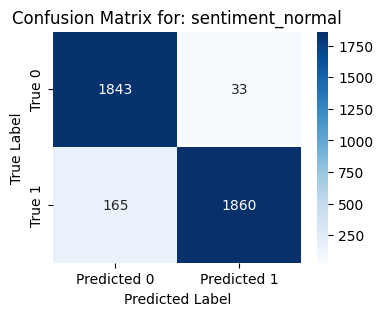

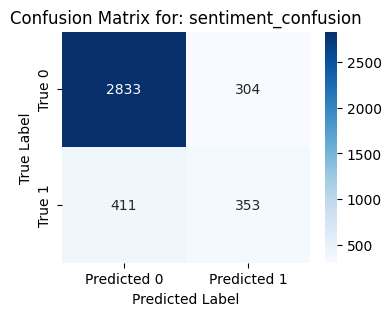

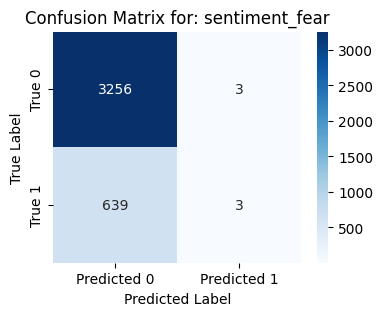

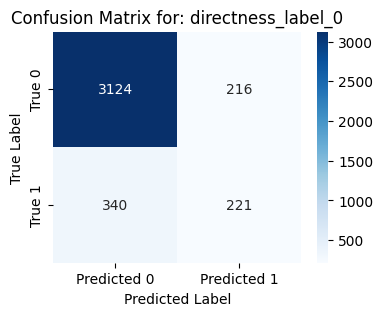

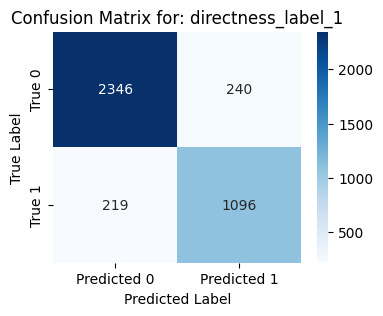

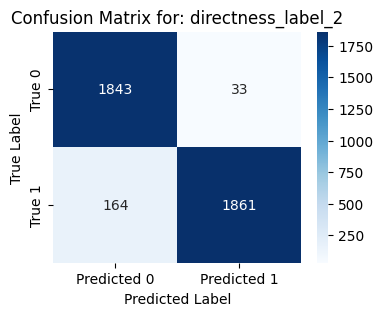

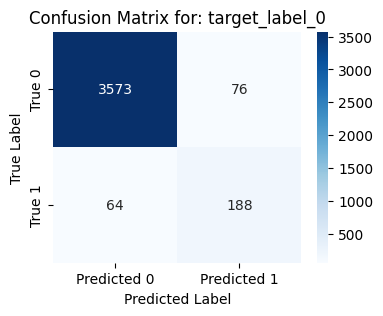

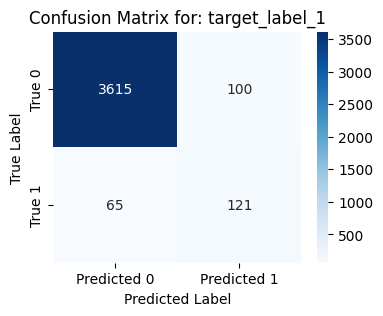

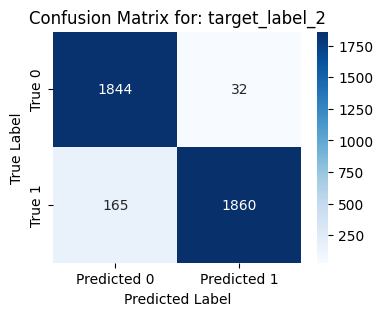

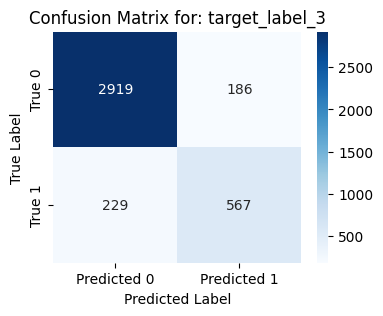

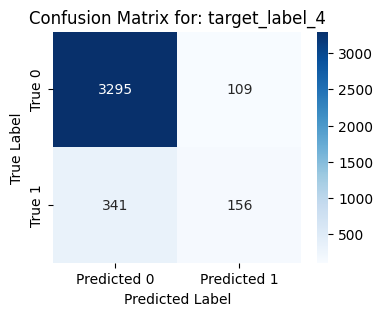

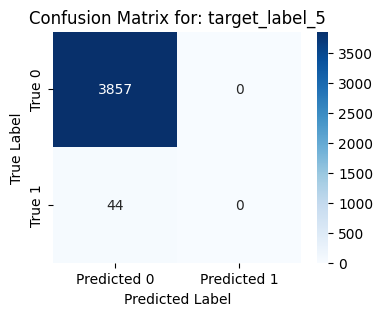

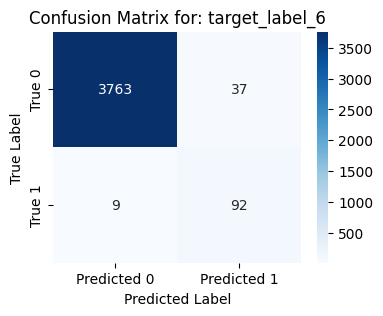

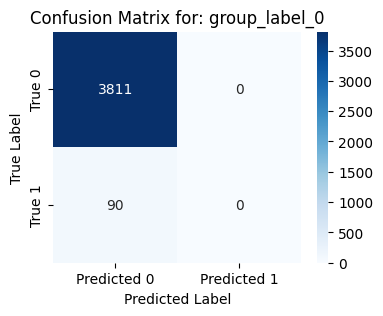

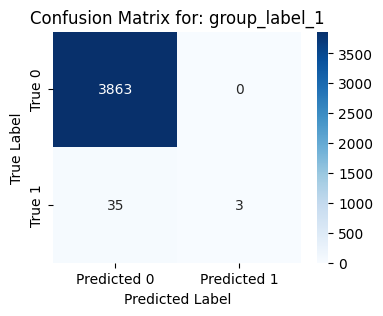

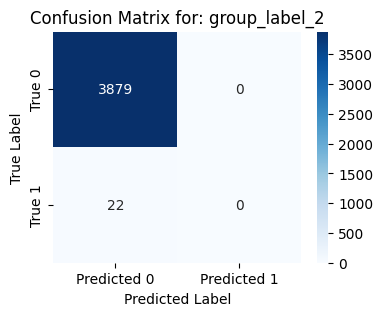

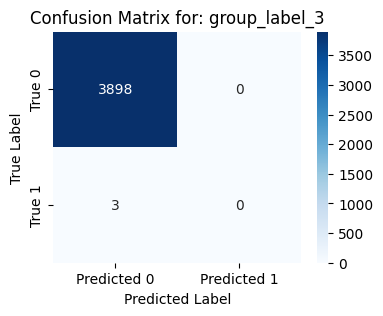

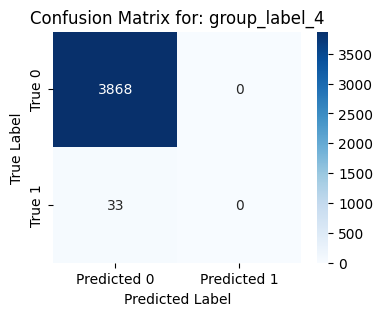

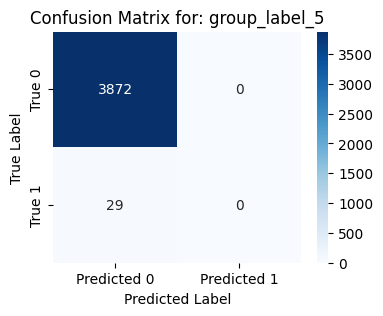

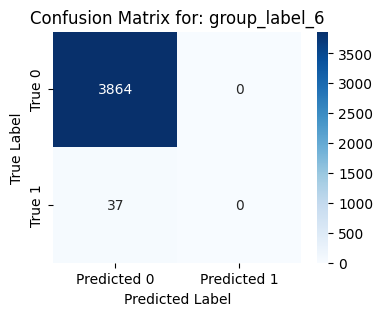

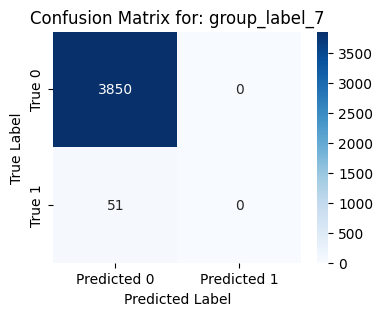

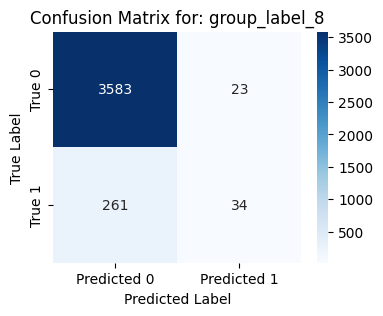

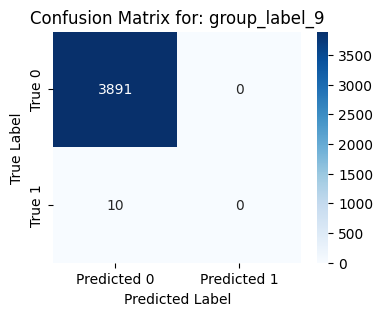

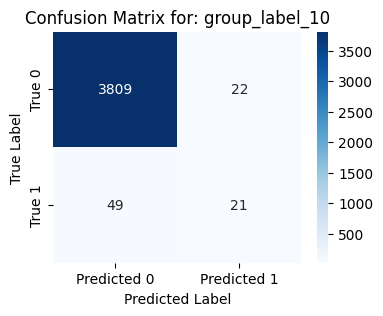

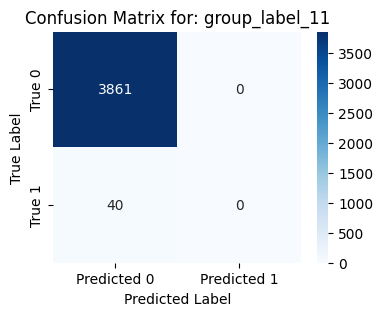

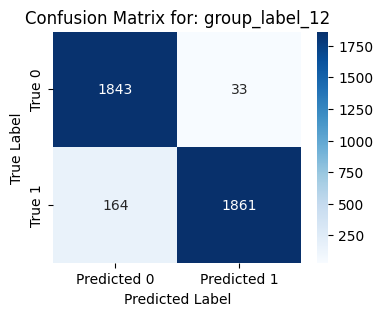

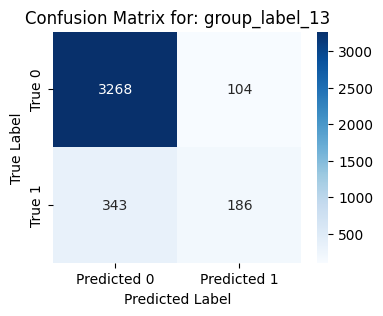

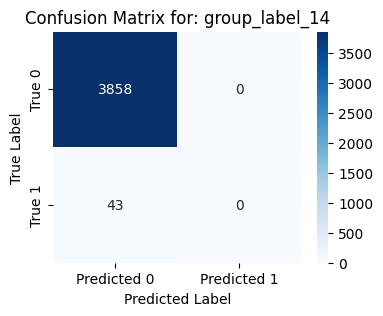

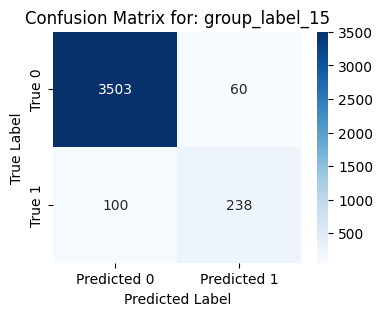

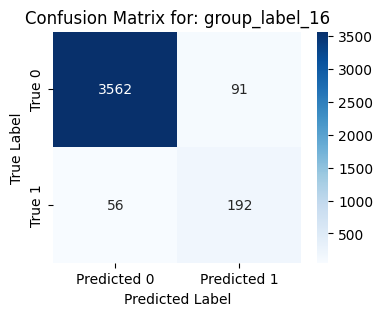

In [ ]:
# Visualize Confusion Matrices for each individual binary label

# Apply sigmoid to get probabilities
sigmoid = torch.nn.Sigmoid()
predicted_probs_np = sigmoid(torch.Tensor(predicted_logits_np)).numpy()

# Apply threshold to get binary predictions for each label
predicted_binary_labels_np = (predicted_probs_np >= 0.5).astype(int)


# Iterate through each binary label and plot its confusion matrix
for i, label_name in id2label.items():
    true_binary = true_labels_np[:, i]
    predicted_binary = predicted_binary_labels_np[:, i]

    # Calculate confusion matrix for the current binary label
    cm = confusion_matrix(true_binary, predicted_binary)

    # Plot the confusion matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for: {label_name}')
    plt.show()

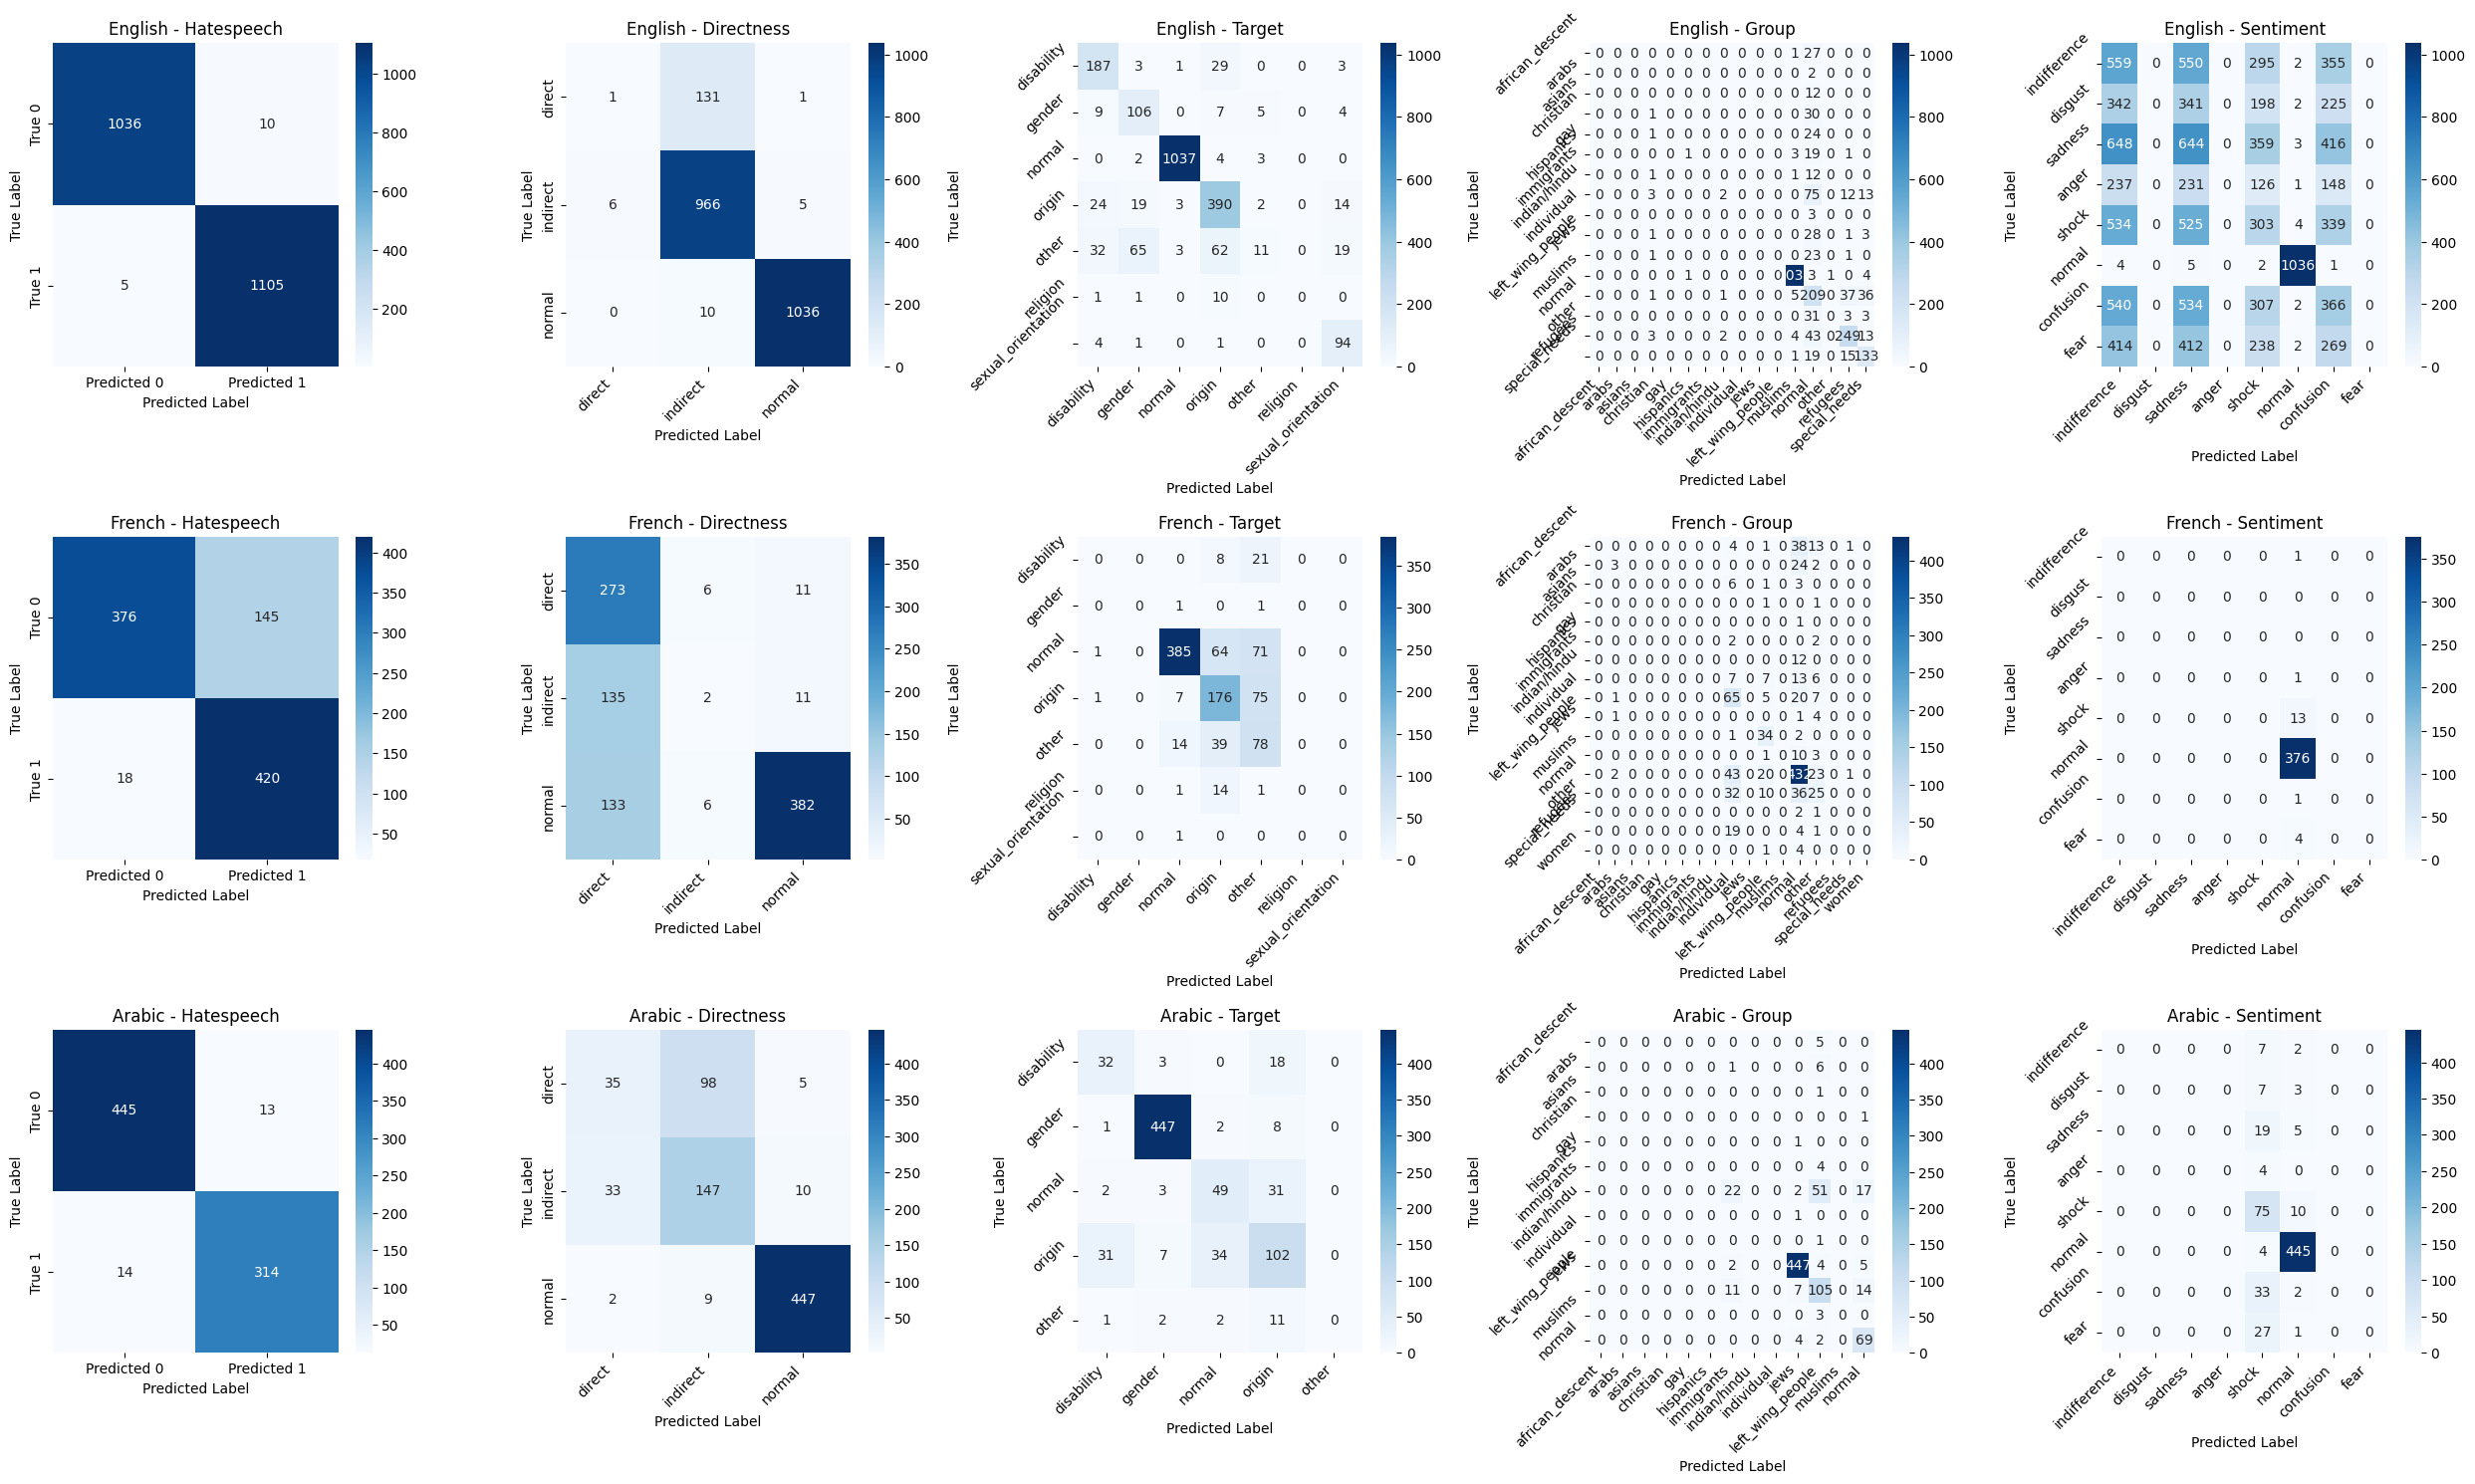

In [38]:
# 1. Create a 3x5 figure and a set of subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15)) # Increased figure size

# 2. Define the order of languages and categories
languages_order = ['english', 'french', 'arabic']
categories_order = ['hatespeech', 'directness', 'target', 'group', 'sentiment'] # Changed order

# Define mappings for sentiment labels for plotting
sentiment_labels = [label.replace('sentiment_', '') for label in binary_label_columns if 'sentiment' in label]


# 3. Iterate through each language (row) and each category (column)
for i, lang in enumerate(languages_order):
    for j, category in enumerate(categories_order):

        # 4. Retrieve the corresponding confusion matrix(es)
        cm_data = confusion_matrices[lang][category]

        # 5. Select the appropriate subplot axis
        ax = axes[i, j]

        # 6. Generate a heatmap for the current confusion matrix
        sns.heatmap(cm_data, annot=True, fmt='d', cmap='Blues', ax=ax)

        # 7. & 8. Set the x-axis and y-axis tick labels
        if category == 'hatespeech':
            ax.set_xticklabels(['Predicted 0', 'Predicted 1'])
            ax.set_yticklabels(['True 0', 'True 1'])
        elif category == 'sentiment':
            # Set tick labels for the 8x8 sentiment matrix
            ax.set_xticklabels(sentiment_labels, rotation=45, ha='right')
            ax.set_yticklabels(sentiment_labels, rotation=45, ha='right') # Apply 45 degree rotation to y-axis labels

        else:
            # Retrieve the label mapping for the category
            mapping = category_label_mappings[category]
            # Get the number of classes in the current confusion matrix
            num_classes = cm_data.shape[0]
            # Get the keys (original label indices) from the mapping
            mapping_keys = list(mapping.keys())
            # Ensure we don't go out of bounds for the mapping keys
            if num_classes <= len(mapping_keys):
                # Create tick labels based on the mapping values for the present classes
                tick_labels = [mapping[mapping_keys[k]] for k in range(num_classes)]
                ax.set_xticklabels(tick_labels, rotation=45, ha='right') # Rotate labels for better readability
                if category in ['target', 'group']: # Apply rotation only for target and group
                    ax.set_yticklabels(tick_labels, rotation=45, ha='right') # Apply 45 degree rotation to y-axis labels
                else:
                    ax.set_yticklabels(tick_labels)
            else:
                print(f"Warning: Number of classes in confusion matrix ({num_classes}) for {lang} - {category} exceeds the number of labels in mapping ({len(mapping_keys)}). Using default numerical labels.")


        # 9. Set the title of each subplot
        ax.set_title(f'{lang.capitalize()} - {category.capitalize()}')

        # 10. Add labels to the x and y axes
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

# 11. Adjust the layout of the subplots
plt.tight_layout()

# 12. Display the plot
plt.show()

## Summary:

### Data Analysis Key Findings

*   The dataset was successfully separated into subsets for English, French, and Arabic languages.
*   True labels and predicted logits for 'Hatespeech', 'Sentiment', 'Directness', 'Target', and 'Group' categories were extracted and stored for each language.
*   Confusion matrices were calculated for each language and category combination. For 'Hatespeech', a standard confusion matrix was computed. For the multi-label categories ('Sentiment', 'Directness', 'Target', 'Group'), confusion matrices were calculated on the flattened true and predicted binary label arrays, resulting in 2x2 matrices.
*   A 3x5 subplot was generated to visualize the confusion matrices, with rows representing languages and columns representing categories. Each subplot was titled with the corresponding language and category.

### Insights or Next Steps

*   While the confusion matrices were visualized, the axis labels for 'Directness', 'Target', and 'Group' could be enhanced to reflect the specific categories (e.g., 'direct', 'indirect', 'normal' for Directness) instead of generic '0' and '1' to provide clearer insights into misclassifications within those categories.
*   Analyze the confusion matrices to identify which languages and categories show the highest and lowest prediction performance, potentially indicating areas for model improvement or further investigation into data characteristics.
